# Experiment 1-B

This experiment used the full corpus of 6K+ texts scraped from JSTOR, and this time the data is segmented according to chapter. 

In [1]:
import pandas as pd
%matplotlib inline
from ast import literal_eval
import numpy as np
import re
import json
from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]

In [2]:
with open('middlemarch.txt') as f: 
    mm = f.read()

In [3]:
textALength = len(mm) 

In [4]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [5]:
with open('txt/e1a.json') as f: 
    rawData = f.read()

In [6]:
df = pd.read_json(rawData)

In [7]:
df['Decade'] = df['year'] - (df['year'] % 10)
df['Locations in A'] = df['matches'].apply(lambda x: x[1])

In [8]:
def diachronicAnalysis(df, decades=(1950, 2020)): 
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locations = row['Locations in A']
        if decade not in decadeDict: 
            decadeDict[decade] = locations
        else: 
            decadeDict[decade] += locations 
    # Grab the beginnings of quotes. 
    decadeStarts = {decade: [item[0] for item in loc] for decade, loc in decadeDict.items()}
    decadesBinned = {decade: 
                 np.histogram(locations, bins=chapterLocations, range=(0, textALength))[0]
                 for decade, locations in decadeStarts.items() if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def synchronicAnalysis(df): 
    allLocations = []
    for i, row in df.iterrows(): 
        locations = row['Locations in A']
        starts = [item[0] for item in locations]
        for start in starts: 
            allLocations.append(start)
    binned = np.histogram(allLocations, bins=chapterLocations, range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.title("Frequency of Quotations from George Eliot's Middlemarch in Criticism, By Decade")
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    plt.show()
    
def plotSynchronicAnalysis(s): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Quotations')

In [9]:
synchronicAnalysis(df).max()

227

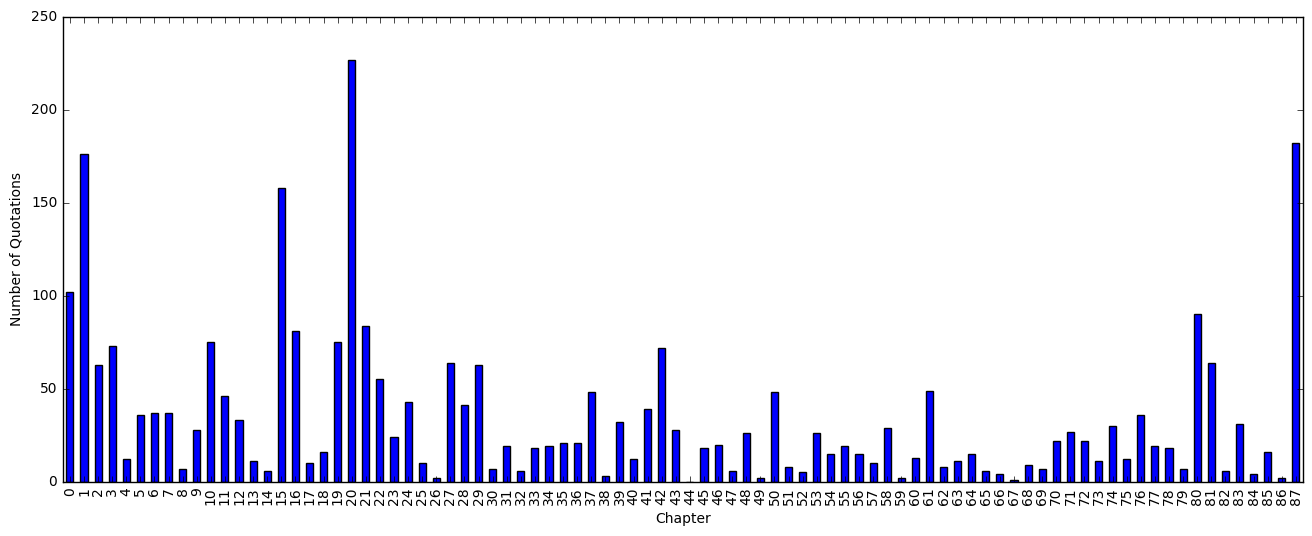

In [10]:
plotSynchronicAnalysis(synchronicAnalysis(df))

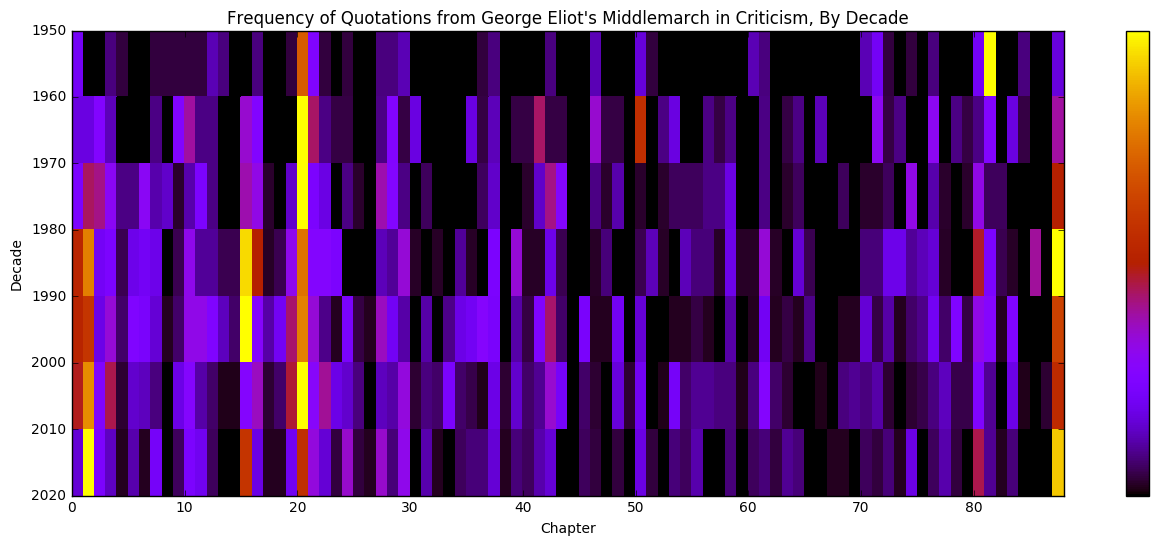

In [11]:
plotDiachronicAnalysis(diachronicAnalysis(df))

# By (Guessed) Gender of Author

In [12]:
maleNames, femaleNames = names.words('male.txt'), names.words('female.txt')
maleNames = [name.lower() for name in maleNames]
femaleNames = [name.lower() for name in femaleNames]

In [13]:
def guessGender(name): 
    name = name.split()[0].lower() # Grab the first name. 
    if name in maleNames and name in femaleNames: 
        return 'A' #Ambiguous
    elif name in maleNames: 
        return 'M'
    elif name in femaleNames: 
        return 'F'
    else: 
        return 'U'

def averageGender(names): 
    if type(names) != list: 
        return 'U'
    genderGuesses = [guessGender(name) for name in names]
    stats = Counter(genderGuesses).most_common()
    if len(stats) == 1: 
        # Only one author. We can just use that's author's gender guess. 
        return stats[0][0]
    elif stats[0][1] == stats[1][1]: # There's a tie. 
        return 'A' # Ambiguous. 
    else: 
        return stats[0][0] # Return the most common gender. 
        

In [14]:
df['gender'] = df['author'].apply(averageGender)
dfF = df.loc[df['gender'] == 'F']
dfM = df.loc[df['gender'] == 'M']

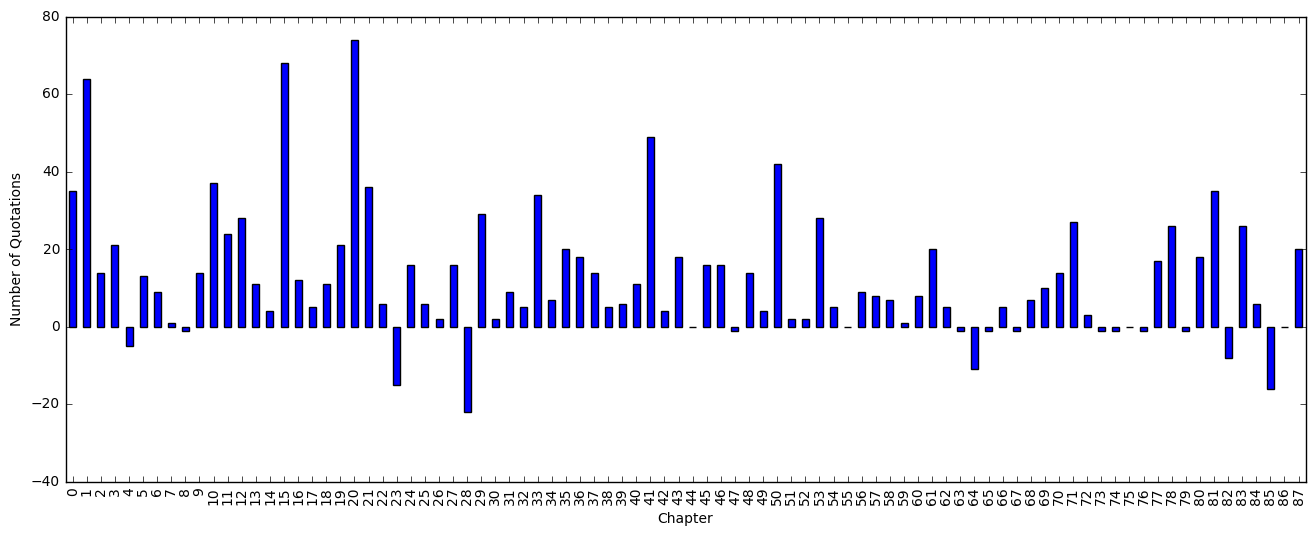

In [15]:
# Differences in citations between genders. 
plotSynchronicAnalysis(synchronicAnalysis(dfM) - synchronicAnalysis(dfF))

# By (Guessed) Country of Publication

In [16]:
def getFirst(row): 
    if type(row) == list: 
        return row[0]
    else: 
        return row

topPublishers = df['publisher_name'].apply(getFirst).value_counts()

In [17]:
publishers = topPublishers[:80].index

In [18]:
publishers = publishers.tolist()

In [19]:
def getCountry(publisher): 
    brits = ['Oxford University Press', 'Cambridge University Press', 'Modern Humanities Research Association', \
             'BMJ', 'Taylor & Francis, Ltd.', 'Edinburgh University Press', \
             'Royal Society for the Encouragement of Arts, Manufactures and Commerce']
    canadians = ['Victorian Studies Association of Western Canada'] 
    if type(publisher) != list: 
        return 'Unknown'
    publisher = publisher[0]
    if publisher in brits: 
        return 'Britain' 
    elif publisher in canadians or 'Canada' in publisher: 
        return 'Canada' 
    elif 'GmbH' in publisher: 
        return 'Germany'
    elif 'estudios' in publisher: 
        return 'Spain'
    elif 'France' in publisher: 
        return 'France' 
    elif 'Ireland' in publisher: 
        return 'Ireland'
    else: 
        return 'US'

In [20]:
df['country'] = df['publisher_name'].apply(getCountry)

In [21]:
df['country'].value_counts()

US         3901
Unknown    1247
Britain     825
Canada       59
Germany      15
Spain         8
Ireland       8
France        6
Name: country, dtype: int64

In [22]:
dfBrits = df.loc[df['country'] == 'Britain']
dfYanks = df.loc[df['country'] == 'US']
dfCanadians = df.loc[df['country'] == 'Canada']

In [23]:
# Since British authors are greatly outnumbered in this corpus, we should normalize the data. 
britsHist = synchronicAnalysis(dfBrits) 
normBrits = britsHist.div(britsHist.max())
yanksHist = synchronicAnalysis(dfYanks)
normYanks = yanksHist.div(yanksHist.max())

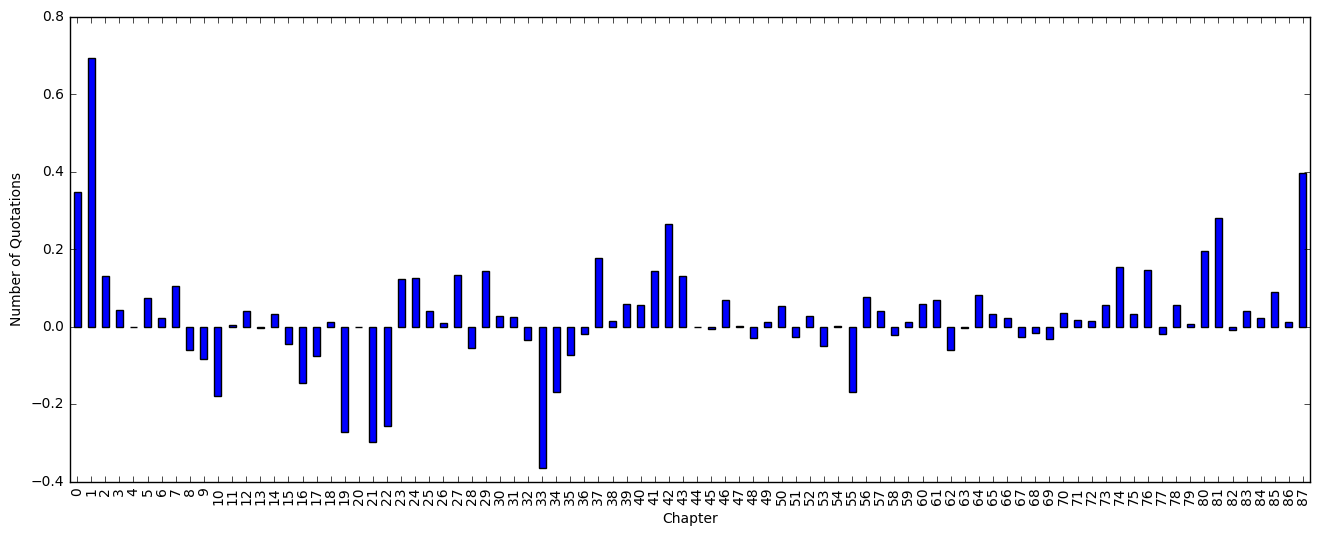

In [24]:
plotSynchronicAnalysis(normYanks - normBrits)

# By Journal

In [25]:
# Look at the top journals. 
df['journal'].value_counts()[:10]

Victorian Studies                            424
George Eliot - George Henry Lewes Studies    206
Nineteenth-Century Fiction                   192
The Modern Language Review                   188
The Review of English Studies                185
Nineteenth-Century Literature                126
NOVEL: A Forum on Fiction                    126
Studies in the Novel                         120
Studies in English Literature, 1500-1900      85
ELH                                           77
Name: journal, dtype: int64

Compare the specialist journal, "George Eliot - George Henry Lewes Studies," with all other journals. 

In [26]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [27]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

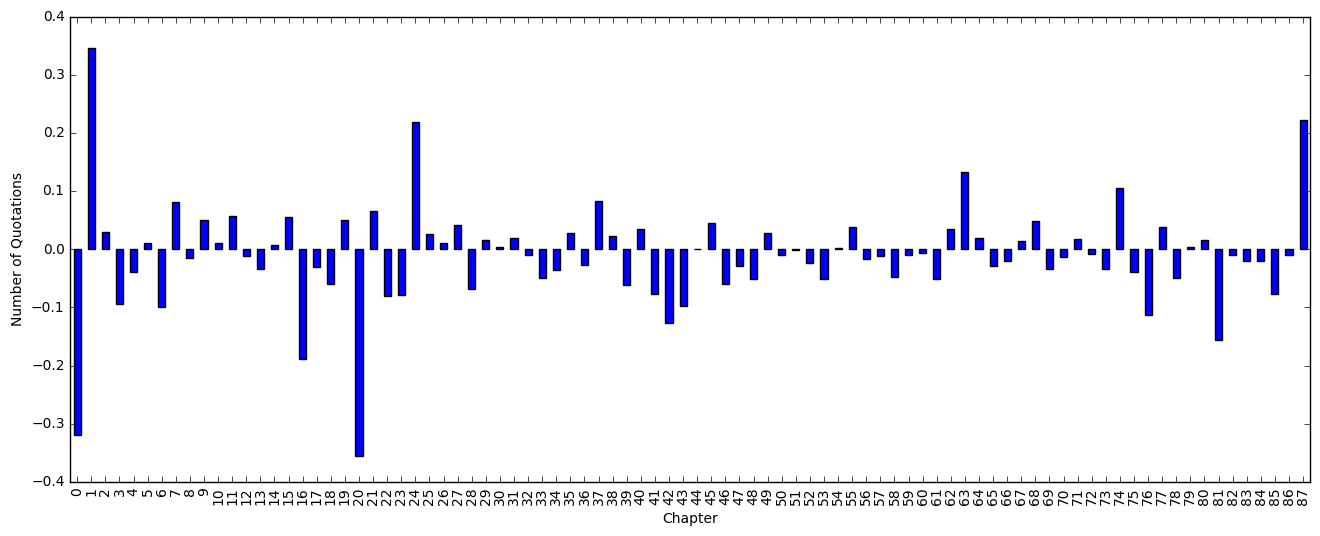

In [30]:
plotSynchronicAnalysis(normGE - normOther)